In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import h5py
data_path = 'data/pca32v2/10M/dataset.h5'
%time f = h5py.File(data_path, 'r')

CPU times: user 1.25 ms, sys: 174 ms, total: 175 ms
Wall time: 200 ms


In [3]:
%time loaded_data = f['pca32'][:, :]

CPU times: user 3.29 ms, sys: 1.52 s, total: 1.52 s
Wall time: 11.4 s


In [17]:
import pandas as pd
data = pd.DataFrame(loaded_data)
data.index += 1
#data_s = data.sample(5_000_000, random_state=2023)

## Goal:
1) load data for training (1000*1000 objects)
2) train, predict on train, dispose of the training data (keep ids)
3) load data for predict (rest 9M objects)
4) predict, dispose of the data (keep ids)
5) on search, load the data in the visited bucket again (10k objects on avg), compute distances

In [4]:
import pickle

In [6]:
with open('../models/clip768v2-emb-10M-50-0.3-50-0.1-Bigger.pkl.pkl', 'rb') as f:
    blmi = pickle.load(f)

In [8]:
blmi.dump_structure()

,type,children
key,,
"(0,)",InnerNode,50
"(0, 0)",InnerNode,50
"(0, 0, 0)",LeafNode,4162
"(0, 0, 1)",LeafNode,3681
"(0, 0, 2)",LeafNode,3628
...,...,...
"(0, 49, 45)",LeafNode,7460
"(0, 49, 46)",LeafNode,2775
"(0, 49, 47)",LeafNode,5881


In [7]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(levelname)-5.5s][%(name)-.20s] %(message)s'
)
LOG = logging.getLogger(__name__)


In [12]:
#clf = LogisticRegression(random_state=0).fit(X, y)

In [9]:
base_path = 'data/clip768v2/10M/'
base_path = 'data/pca32v2/10M/'

In [10]:
%%time
queries_path = f'{base_path}/query.h5'
f2 = h5py.File(queries_path, 'r')
#loaded_queries = f2['emb'][:, :]
loaded_queries = f2['pca32'][:, :]

CPU times: user 3.55 ms, sys: 1.52 ms, total: 5.06 ms
Wall time: 20.7 ms


In [11]:
%%time
gt_path = f'data/groundtruth-10M.h5'
f3 = h5py.File(gt_path, 'r')
loaded_gt = f3['knns'][:, :]

CPU times: user 8.16 ms, sys: 53 µs, total: 8.22 ms
Wall time: 70.5 ms


In [12]:
from tqdm import tqdm
from li.utils import pairwise_cosine


In [13]:
def increase_max_recursion_limit():
    """ Increases the maximum recursion limit.
    Source: https://stackoverflow.com/a/16248113
    """
    import sys
    import resource
    resource.setrlimit(resource.RLIMIT_STACK, (2**29, -1))
    sys.setrecursionlimit(10**6)
increase_max_recursion_limit()

In [18]:
%%time
res_all = []
for i, query in tqdm(enumerate(loaded_queries)):
    pred_leaf_nodes = blmi.search(query, stop_condition=1_000_000)[0]
    object_ids = []
    for pred_leaf_node in pred_leaf_nodes:
        leaf_node = blmi.nodes.get(pred_leaf_node)
        if leaf_node is not None:
            object_ids.extend(leaf_node.object_ids)

    #bucket_ids = [[i, mapping[bucket]] for bucket in blmi.search(query, stop_condition=500)[0]]
    dists = pairwise_cosine([query], data.loc[object_ids])
    break
    res_all.extend(bucket_ids)

0it [00:00, ?it/s]

CPU times: user 515 ms, sys: 141 ms, total: 656 ms
Wall time: 819 ms


In [19]:
len(object_ids)

1004779

In [22]:
%%time
base_path = 'data/clip768v2/10M/'
queries_path = f'{base_path}/query.h5'
f2 = h5py.File(queries_path, 'r')
#loaded_queries = f2['emb'][:, :]
loaded_queries_seq = f2['emb'][:, :]

CPU times: user 0 ns, sys: 38.5 ms, total: 38.5 ms
Wall time: 286 ms


In [23]:
import h5py
data_path = 'data/clip768v2/10M/dataset.h5'
%time f = h5py.File(data_path, 'r')
%time loaded_clip_data = f['emb'][:, :]

CPU times: user 0 ns, sys: 1.71 s, total: 1.71 s
Wall time: 1.86 s
CPU times: user 0 ns, sys: 16.8 s, total: 16.8 s
Wall time: 3min 11s


In [26]:
clip_data = pd.DataFrame(loaded_clip_data)
clip_data.index += 1

In [122]:
len(object_ids)

485585

In [124]:
%%time
dists = pairwise_cosine([loaded_queries_seq[0]], clip_data.loc[object_ids[:10_000]])

CPU times: user 103 ms, sys: 43.7 ms, total: 147 ms
Wall time: 158 ms


In [125]:
%%time
dists = pairwise_cosine(loaded_queries_seq, clip_data.loc[object_ids[:10_000]])

CPU times: user 5.25 s, sys: 605 ms, total: 5.85 s
Wall time: 6.18 s


In [119]:
%time dists = pairwise_cosine([loaded_queries_seq[0]], clip_data.loc[object_ids])

CPU times: user 4.41 s, sys: 2.83 s, total: 7.24 s
Wall time: 7.69 s


In [120]:
dists.shape

(1, 485585)

In [31]:
import numpy as np
k = 10

In [32]:
np.intersect1d(
    loaded_gt[0][:10],
    np.array(data.loc[object_ids].index[np.argsort(dists)[:, :k][0]])[:10]
).shape

(9,)

### Search speed-up
1. eval pred_proba of root, pick 4 highest
2. eval pred_proba of 4 highest, pick x highest
3. evaluate navigation time
    - 24ms instead of 819ms for 1M objects
3. save, do sequential search, evaluate seq search time
4. **parallelize over all the queries**

In [34]:
query

array([-0.06877425, -0.11037602,  0.05646035, -0.11508854, -0.03577028,
        0.09110859,  0.07477964,  0.10778218,  0.04116842,  0.00877987,
       -0.06257925, -0.17031246,  0.00780125, -0.099485  ,  0.04967897,
       -0.12064676,  0.0035742 , -0.07642894,  0.08400699, -0.03188556,
       -0.01020392,  0.07147753, -0.01378688, -0.10539152, -0.00040444,
       -0.00291365,  0.12945361,  0.05624911,  0.00785595,  0.01020052,
        0.06252866, -0.00992952], dtype=float32)

In [39]:
from li.model import data_X_to_torch

### For 1 query

In [100]:
%%time

object_ids = []

L1_res, _ = blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(query))
top_L1_cats = np.argsort(L1_res)[-10:]
for cat in top_L1_cats:
    L2_res, _ = blmi.nodes[(0, cat)].nn.predict_proba(data_X_to_torch(query))
    top_L2_cats = np.argsort(L2_res)[-10:]
    for cat2 in top_L2_cats:
        leaf_node = blmi.nodes.get(((0, cat, cat2)))
        if leaf_node is not None:
            object_ids.extend(leaf_node.object_ids)

CPU times: user 24.1 s, sys: 5.88 s, total: 30 s
Wall time: 31.3 s


In [101]:
len(object_ids)

485585

In [102]:
# pre-filter with cheaper pairwise
%time dists_pca = pairwise_cosine([loaded_queries[0]], data.loc[object_ids])

CPU times: user 223 ms, sys: 48 ms, total: 271 ms
Wall time: 285 ms


In [111]:
dists_pca

array([[0.7125033 , 0.69720864, 0.74264336, ..., 0.27290726, 0.27820122,
        0.2963873 ]], dtype=float32)

In [113]:
np.argsort(dists_pca)[:, :50_000][0]

array([482740, 481235, 483399, ..., 439205,  96883, 417001])

In [115]:
dists_pca[0][np.argsort(dists_pca)[:, :100_000][0]]

array([0.07507682, 0.08240354, 0.08386886, ..., 0.53746855, 0.53747296,
       0.53747356], dtype=float32)

In [ ]:
np.argsort(dists_pca)[:, :50_000][0]

In [116]:
# this is the biggest bottleneck
%time dists = pairwise_cosine([loaded_queries_seq[0]], clip_data.loc[np.argsort(dists_pca)[:, :100_000][0]])

CPU times: user 928 ms, sys: 590 ms, total: 1.52 s
Wall time: 1.57 s


In [117]:
np.intersect1d(
    loaded_gt[0][:10],
    np.array(data.loc[object_ids].index[np.argsort(dists)[:, :k][0]])[:10]
).shape

(0,)

### For multiple queries

In [95]:
%%time

object_ids = {}

L1_res, _ = blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(loaded_queries))
top_L1_cats = np.argsort(L1_res)[:, -10:]
# TODO: Poor parallelization, only at root node
for i, query_cats in enumerate(top_L1_cats):
    object_ids[i] = []
    for cat in query_cats:
        L2_res, _ = blmi.nodes[(0, cat)].nn.predict_proba(data_X_to_torch(loaded_queries[i]))
        top_L2_cats = np.argsort(L2_res)[-10:]
        for cat2 in top_L2_cats:
            leaf_node = blmi.nodes.get(((0, cat, cat2)))
            if leaf_node is not None:
                object_ids[i].extend(leaf_node.object_ids)

CPU times: user 2min 33s, sys: 22.8 s, total: 2min 55s
Wall time: 3min 1s


In [ ]:
%time dists = pairwise_cosine([loaded_queries_seq[0]], clip_data.loc[object_ids[i]])

<AxesSubplot:>

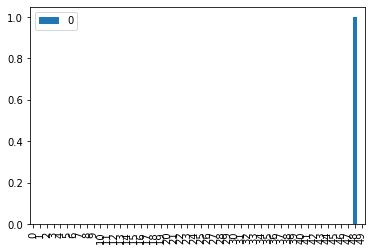

In [47]:
pd.DataFrame(res[0]).plot.bar()

In [60]:
%time np.argsort(res[0])[-4:]

CPU times: user 105 µs, sys: 104 µs, total: 209 µs
Wall time: 214 µs


array([15, 49, 38, 48])

In [61]:
%%time
res2 = blmi.nodes[(0, 48)].nn.predict_proba(data_X_to_torch(query))
np.argsort(res2[0])[-4:]

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 37.4 µs
CPU times: user 2.5 ms, sys: 0 ns, total: 2.5 ms
Wall time: 2.74 ms


array([19, 44, 29, 40])

In [63]:
%%time
res2 = blmi.nodes[(0, 38)].nn.predict_proba(data_X_to_torch(query))
np.argsort(res2[0])[-4:]

CPU times: user 823 µs, sys: 798 µs, total: 1.62 ms
Wall time: 1.63 ms


array([32,  5, 41,  2])

<AxesSubplot:>

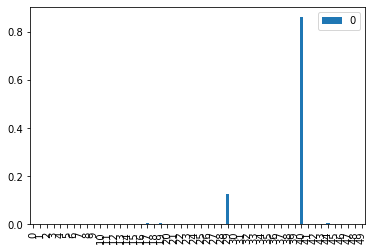

In [49]:
pd.DataFrame(res[0]).plot.bar()